In [ ]:
#这个字符串变量难以实现，此部分仅作备份之用

%matplotlib inline
from fractions import Fraction
from decimal import Decimal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def Unnamed(colnames):
    for n in colnames:
        if n[:7]=="Unnamed":
            yield n
df=pd.read_csv('ET_MAP.csv')
a=[x for x in Unnamed(df.columns)]
#print(df.columns)
df.drop(columns=a,inplace=True)
df.dropna(axis=0,how='all',inplace=True)
df.dropna(axis=1,how='all',inplace=True)
df.drop(columns=['TB','w/ PLV \nor PCV','Tem.','Test No','Armature lift'],inplace=True)
df['Nozzle Flow Rate_ cm3/30s@100bar']=df['Nozzle Flow Rate_ cm3/30s@100bar'].map(pd.to_numeric)
#print(df.iloc[1].to_dict())

from sklearn import preprocessing  
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
w=vec.fit_transform(df.to_dict('records')).toarray()

df=pd.DataFrame(w,columns=vec.get_feature_names())
#df.to_dict('records')
#print(array)
#vec.get_feature_names()

In [1]:
#导入数据,清除空列以及非数字列
#清除空行
from fractions import Fraction
from decimal import Decimal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def Unnamed(colnames):#空列都是以Unnamed:开头的
    for n in colnames:
        if n[:7]=="Unnamed":
            yield n
df=pd.read_csv('ET_MAP.csv')#这是总结的表格
a=[x for x in Unnamed(df.columns)]
#print(df.columns)

df.drop(columns=a,inplace=True)
df.dropna(axis=0,how='all',inplace=True)#清除空行,整行都是空的
df.dropna(axis=1,how='all',inplace=True)#清除空列
df=df[~df['Injector  Type'].str.startswith('CRIN')]
df.drop(columns=['TB','w/ PLV \nor PCV','Tem.','Test No','Armature lift'],inplace=True)#清除无效数据
df['Nozzle Flow Rate_ cm3/30s@100bar']=df['Nozzle Flow Rate_ cm3/30s@100bar'].map(pd.to_numeric)
#把油嘴流率转换成数字

df.drop(df.select_dtypes(['object']).columns,axis=1,inplace=True)#清除非数字列
print("done")

done


In [12]:
#将ET_MAP raw data 合并到数据中并存成新的文件，避免反复读取
def getCSV(mid):
    fname="{0:03d}".format(int(mid))
    df1=pd.read_csv('01_ETMAP mean value data//'+fname + '.csv',skiprows=1,index_col=1)
    #print(df1)
    #df1=df1.drop(['Unnamed: 0'],axis=1)
    del df1['Unnamed: 0']
    
    #df1=df1[['250000','1000000','1400000']]

    #df1['ID']=1.0
    
    df1.index.name="ET"
    #print(df1)
    df2=pd.DataFrame(df1.stack())
    #df2['ET2']=df2.index.droplevel(1)
    #df2['Railp']=df2.index.droplevel()
    df2.reset_index(level=0, inplace=True)
    df2.reset_index(level=0, inplace=True)
    df2.columns=['RailP','ET','InjQ']
    #df2['ID']=float(id)
    df2.index.name="ID"
    df2.index=[id] * len(df2.index)
    df2=df2.loc[(df2.ET <= 200) | ((df2.ET % 30==0) & (df2.ET<=500) & (df2.ET>200)) | ((df2.ET % 150==0) & (df2.ET<=2500) & (df2.ET>500))]
    #print(df2.head(5))
    return df2
    #df.merge(df1,how='left')
    #df[df['ID']==1.0]

af=pd.DataFrame()
for i in sorted(df['ID']):
    if i not in [112,181,182,183,253,257,258] :
        
        try:
            #print("Merging : ",i)
            t=getCSV(i)
            #t=t[t["ET"]<1000]
            t.loc[t.InjQ<0,'InjQ']=0
            leftf=df[df['ID']==i] # prepare left dataframe
            rightf=t #right dataframe
            joined=leftf.join(rightf,on=["ID"])
            af=af.append(joined)
            #print("shape of af: ",af.shape)
            #print(af.head(2))
        except Exception as e:
            print(e, " Warning! For test number {0} ".format(i),)

af.dropna(inplace=True)
af.to_csv("CRIN.csv")
print('done')

done


In [19]:
#Calc importance
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
af=pd.read_csv("x.csv")
af.drop(columns=["Unnamed: 0","ID"],inplace=True)
X=af.iloc[:,:-1].values
y=af.iloc[:,-1:].values
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
def ploynomial_model(degree=1):
    ploynomial_features = PolynomialFeatures(degree=degree,include_bias=True)
    #NN_REG=MLPRegressor()
    Linear_Regression = LinearRegression()
    pipeline = Pipeline([("ploynomial_features",ploynomial_features),
                        ("Linear_Regression",Linear_Regression)])
    #pipeline = Pipeline([("NN_REG",NN_REG),
    #                    ("Linear_Regression",Linear_Regression)])
    return pipeline
n_neighbors=5
lr=KNeighborsRegressor(n_neighbors, weights='uniform')
#lr = ploynomial_model(degree=3)
#lr=MLPRegressor(hidden_layer_sizes=(100, 100, 100,))
lr.fit(X_train,y_train)

names=af.iloc[:,:-1].columns
af.iloc[:1,:].to_csv("Pred.txt")

#def getkey(tup):
#    return tup[0]
#d=sorted(zip(lr.named_steps['linear_regression'].coef_[0],names))
#d=sorted(zip(lr.coef_,names))
#print(lr.coef_)
#for x in d: print(x[1],":%.3e" % x[0])
filename = 'etmap_model.sav'
pickle.dump(lr, open(filename, 'wb'))
#h=[i for i in zip(*d)]
#def plot_importance(model):
#    #n_f=len(model.feature_importances_)
#    f=plt.figure(figsize=(8,6))
#    plt.barh(h[1],h[0],align='center')
    #plt.yticks(np.arange(n_f),names)
#plot_importance(lr)
print("Train Score: %.3f" % lr.score(X_train,y_train))    
print("Validatin Score: %.3f" % lr.score(X_test,y_test))


Train Score: 1.000
Validatin Score: 1.000


Tem.                                    40.0000
Inj. Back pressure                       0.5000
Cylinder                                 4.0000
No. of Plunger                           1.0000
No. of Lobe                              3.0000
Devolume                              1408.0000
Plunger lift_mm                          8.3000
Needle Lift                              0.8500
Nozzle Flow Rate_ cm3/30s@100bar       500.0000
holes Num.                               6.0000
DSP                                      0.1507
Volume                                  15.0000
HPP P2R_Length                         365.0000
HPP P2R_ID                               3.0000
HPP P2R_OD                               6.3500
HPP R2I_Length                         168.0000
HPP R2I_ID                               3.0000
HPP R2I_OD                               6.3500
RailP                               300000.0000
ET                                      80.0000
Name: 0, dtype: float64


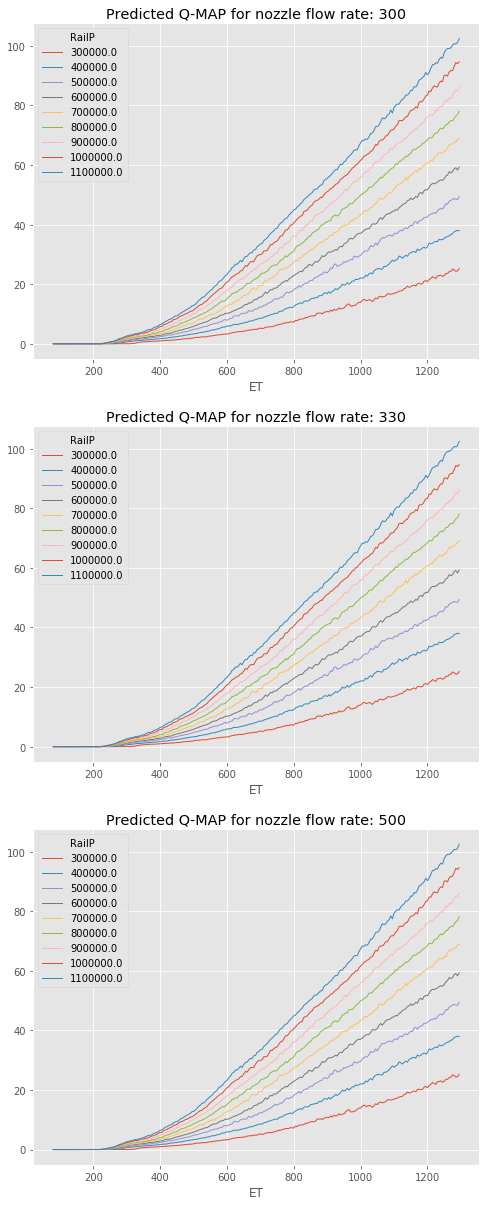

In [28]:
#产生新的虚拟测试需求 ，填充y并画出Q-MAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import pickle


def make_X(flow):
    
    tlf=pd.read_csv("Pred.txt",index_col=0)
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,1300,5)]
    RailP=[p for p in range(300000,1200000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    tf['Devolume ']=1408
    return tf


plt.figure(figsize=(8, 21))
model=pickle.load(open('etmap_model.sav', 'rb'))
flows=[300,330,500]
for i in range(len(flows)):    
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    X_new=make_X(flows[i])    
    y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for nozzle flow rate: {}".format(flows[i]))
print(X_new.iloc[0][:-1])

In [7]:
import pandas as pd
df=pd.DataFrame({"A":['CRI1-16','CRI2-16','CRIN2-16'],"B":[1,2,3]})
df[~df.A.str.startswith('CRIN')]

,A,B
0,CRI1-16,1
1,CRI2-16,2


In [29]:
import statsmodels.api as sm

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
